In [14]:
import numpy as np
import pandas as pd
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from scipy.optimize import minimize
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr
from scipy.special import expit
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from multiprocessing import Pool
from sklearn.metrics import r2_score, mean_squared_error
pd.options.mode.chained_assignment = None

In [2]:
from warnings import simplefilter
simplefilter(action='ignore')

# Data loading and pre-processing

In [3]:
df = pd.read_csv("df_all_raw.csv")
df.columns = list(map(str.lower, df.columns))
df = df.drop(columns=['dataset_id', 'form_id', 'form', 'gloss_in_source', 'iso639p3code', 'mrc_word', 'kucera_francis_frequency'])

In [4]:
x = pd.read_csv('colex_counts.csv')
relevant = df[["concepticon_gloss", "age_of_acquisition", "concreteness", "familiarity", "imagability"]].dropna()
concepts = np.intersect1d(np.intersect1d(x["concept_1"].unique(), x["concept_2"].unique()),relevant["concepticon_gloss"].unique())

In [5]:
mask = (x["concept_1"].isin(concepts)) & (x["concept_2"].isin(concepts))
colex_data = x[mask]
mask2 = (relevant["concepticon_gloss"].isin(concepts))
concept_data = relevant[mask2].groupby("concepticon_gloss").mean()
concept_data.reset_index(inplace=True)

In [6]:
merged_df1 = pd.merge(colex_data, concept_data, left_on='concept_1', 
                     right_on='concepticon_gloss', how='left')
merged_df2 = pd.merge(colex_data, concept_data, left_on='concept_2', 
                     right_on='concepticon_gloss', how='left')

In [7]:
merged_df1.columns = [f'{col}_c1' for col in merged_df1.columns]
merged_df2.columns = [f'{col}_c2' for col in merged_df2.columns]
final_merged_df = pd.concat([merged_df1, merged_df2], axis=1)
final_merged_df.drop(columns=["concepticon_gloss_c1", "concepticon_gloss_c2", 
                              "concept_2_c2", "concept_1_c2", "colexification_count_c2"], inplace=True)

In [8]:
final_merged_df = final_merged_df.rename(columns={"concept_1_c1":"concept_1","concept_2_c1":"concept_2", "colexification_count_c1": "colex_count"})

# Linear Model

In [ ]:
def divide_chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
        
def objective1(params, F1, F2, y):
    weights = params[:-1]
    intercept = params[-1]
    corr_coefficient, _ = pearsonr(y, F1.dot(weights) + F2.dot(weights) + intercept)
    return -corr_coefficient
    
def objective2(params, F1, F2, y):
    weights = params[:-1]
    intercept = params[-1]
    return -spearmanr(y, F1.dot(weights) + F2.dot(weights) + intercept).statistic

def process_iteration(i):
    X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, random_state=i)
    X1_train_scaled = scaler.fit_transform(X1_train)
    X1_test_scaled = scaler.transform(X1_test)
    X2_train_scaled = scaler.fit_transform(X2_train)
    X2_test_scaled = scaler.transform(X2_test)  
    
    params = [1, 1, 1, 1, 0]
    result1 = minimize(objective1, params, args=(X1_train_scaled, X2_train_scaled, y_train), method='Powell')
    result2 = minimize(objective2, params, args=(X1_train_scaled, X2_train_scaled, y_train), method='Powell')

    optimal_weights1 = result1.x
    optimal_weights2 = result2.x
    predictions1_test1 = X1_test_scaled.dot(optimal_weights1[:-1]) 
    predictions2_test1 = X2_test_scaled.dot(optimal_weights1[:-1])
    predictions1_test2 = X1_test_scaled.dot(optimal_weights2[:-1]) 
    predictions2_test2 = X2_test_scaled.dot(optimal_weights2[:-1]) 
    r1, p1 = pearsonr(y_test, predictions1_test1 + predictions2_test1 + optimal_weights1[-1])
    res1 = spearmanr(y_test, predictions1_test1 + predictions2_test1 + optimal_weights1[-1])
    r2, p2 = pearsonr(y_test, predictions1_test2 + predictions2_test2 + optimal_weights2[-1])
    res2 = spearmanr(y_test, predictions1_test2 + predictions2_test2 + optimal_weights2[-1])
    model = LinearRegression()
    model.fit(np.concatenate((X1_train_scaled, X2_train_scaled), axis=1), y_train)
    predictions = model.predict(np.concatenate((X1_test_scaled, X2_test_scaled), axis=1))
    r3, p3 = pearsonr(y_test, predictions)
    res3 = spearmanr(y_test, predictions)
    weight3 = list(model.coef_)
    weight3.append(model.intercept_)
    return optimal_weights1, optimal_weights2, weight3, (r1, p1), res1.statistic, (r2, p2), res2.statistic, (r3, p3), res3.statistic

X1 = final_merged_df[['age_of_acquisition_c1', 'concreteness_c1', 'familiarity_c1', 'imagability_c1']]
X2 = final_merged_df[['age_of_acquisition_c2', 'concreteness_c2', 'familiarity_c2', 'imagability_c2']]
y = final_merged_df['colex_count']
scaler = StandardScaler()

num_iterations = 300

weights1 = []
weights2 = []
weights3 = []
manual_pearsons1 = []
manual_spearmans1 = []
manual_pearsons2 = []
manual_spearmans2 = []
linear_pearsons = []
linear_spearmans = []

n = os.cpu_count() - 2
chunksize = 10
x = list(divide_chunks([i for i in range(num_iterations)], chunksize * n))
for lst in tqdm(x, desc='Getting Iterations'):
    with Pool(processes=n) as pool:
        results = pool.map(process_iteration, lst, chunksize=chunksize)
    for result in results:
        w1, w2, w3, mp1, ms1, mp2, ms2, lp, ls = result
        weights1.append(w1)
        weights2.append(w2)
        weights3.append(w3)
        manual_pearsons1.append(mp1)
        manual_spearmans1.append(ms1)
        manual_pearsons2.append(mp2)
        manual_spearmans2.append(ms2)
        linear_pearsons.append(lp)
        linear_spearmans.append(ls)

In [ ]:
results = pd.DataFrame({"Optimal Weights (pearson objective)": weights1,
              "Optimal Weights (Spearman objective)": weights2,
              "Optimal Weights (Linear Model)": weights3,
              "Manual Pearsons R (pearson objective)": [i[0] for i in manual_pearsons1],
              "Manual Pearsons P (pearson objective)": [i[1] for i in manual_pearsons1], 
              "Manual Spearman (pearson objective)": manual_spearmans1,
              "Manual Pearsons R (Spearman objective)": [i[0] for i in manual_pearsons2],
              "Manual Pearsons P (Spearman objective)": [i[1] for i in manual_pearsons2], 
              "Manual Spearman (Spearman objective)": manual_spearmans2,
              "Linear Pearsons (R)": [i[0] for i in linear_pearsons],
              "Linear Pearsons (P)": [i[1] for i in linear_pearsons], 
              "Linear Spearman": linear_spearmans})
results.to_pickle("results.pkl")

# Logistic Model

In [42]:
def divide_chunks(l, n):
    for i in range(0, len(l), n):
        yield l[i:i + n]
        

def objective1(params, F1, F2, y):
    weights = params[:-1]
    intercept = params[-1]
    return mean_squared_error(y, np.exp(F1.dot(weights) + F2.dot(weights) + intercept) * expit(F1.dot(weights) + F2.dot(weights) + intercept), squared=False) 

def objective2(params, F1, F2, y):
    weights = params[:-1]
    intercept = params[-1]
    return -r2_score(y, np.exp(F1.dot(weights) + F2.dot(weights) + intercept) * expit(F1.dot(weights) + F2.dot(weights) + intercept))

def process_iteration(i):
    X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, random_state=i)
    X1_train_scaled = scaler.fit_transform(X1_train)
    X1_test_scaled = scaler.transform(X1_test)
    X2_train_scaled = scaler.fit_transform(X2_train)
    X2_test_scaled = scaler.transform(X2_test)  
    params = [1, 1, 1, 1, 0]
    result1 = minimize(objective1, params, args=(X1_train_scaled, X2_train_scaled, y_train), method='Powell')
    result2 = minimize(objective2, params, args=(X1_train_scaled, X2_train_scaled, y_train), method='Powell')
    optimal_weights1 = result1.x
    optimal_weights2 = result2.x
    predictions1_test1 = X1_test_scaled.dot(optimal_weights1[:-1]) 
    predictions2_test1 = X2_test_scaled.dot(optimal_weights1[:-1])
    predictions1_test2 = X1_test_scaled.dot(optimal_weights2[:-1]) 
    predictions2_test2 = X2_test_scaled.dot(optimal_weights2[:-1]) 
    r1 = r2_score(y_test, predictions1_test1 + predictions2_test1 + optimal_weights1[-1])
    mse1 = mean_squared_error(y_test, predictions1_test1 + predictions2_test1 + optimal_weights1[-1], squared=False)
    r2 = r2_score(y_test, predictions1_test2 + predictions2_test2 + optimal_weights2[-1])
    mse2 = mean_squared_error(y_test, predictions1_test2 + predictions2_test2 + optimal_weights2[-1], squared=False)
    model = LogisticRegression(solver='newton-cg')
    model.fit(np.concatenate((X1_train_scaled, X2_train_scaled), axis=1), y_train)
    
    predictions = model.predict(np.concatenate((X1_test_scaled, X2_test_scaled), axis=1))
    r3 = r2_score(y_test, predictions, force_finite=False)
    mse3 = mean_squared_error(y_test, predictions, squared=False)

    coefficients = model.coef_
    intercepts = model.intercept_
    weighted_sum_coefficients = np.zeros_like(coefficients[0])
    weighted_sum_intercept = 0

    for class_label, count in zip(model.classes_, [np.count_nonzero(y_train == i) for i in model.classes_]):
        class_index = np.where(model.classes_ == class_label)[0][0]
        weighted_sum_coefficients += count * coefficients[class_index]
        weighted_sum_intercept += count * intercepts[class_index]

    weighted_avg_coefficients = weighted_sum_coefficients / np.sum(model.classes_)
    weighted_avg_intercept = weighted_sum_intercept / np.sum(model.classes_)

    return optimal_weights1, optimal_weights2, weighted_avg_coefficients + [weighted_avg_intercept], r1, mse1, r2, mse2, r3, mse3

In [43]:
X1 = final_merged_df[['age_of_acquisition_c1', 'concreteness_c1', 'familiarity_c1', 'imagability_c1']]
X2 = final_merged_df[['age_of_acquisition_c2', 'concreteness_c2', 'familiarity_c2', 'imagability_c2']]
y = final_merged_df['colex_count']
scaler = StandardScaler()

num_iterations = 300

weights1 = []
weights2 = []
weights3 = []
r1 = []
r2 = []
r3 = []
mse1 = []
mse2 = []
mse3 = []
n = os.cpu_count() - 1
chunksize = 8
x = list(divide_chunks([i for i in range(num_iterations)], chunksize * n))
for lst in tqdm(x, desc='Getting Iterations'):
    with Pool(processes=n) as pool:
        results = pool.map(process_iteration, lst, chunksize=chunksize)
    for result in results:
        w1, w2, w3, mp1, ms1, mp2, ms2, lp, ls = result
        weights1.append(w1)
        weights2.append(w2)
        weights3.append(w3)
        r1.append(mp1)
        mse1.append(ms1)
        r2.append(mp2)
        mse2.append(ms2)
        r3.append(lp)
        mse3.append(ls)

Getting Iterations: 100%|██████████| 6/6 [31:31<00:00, 315.26s/it]


In [44]:
logistic_results =  pd.DataFrame({"Optimal Weights (RMSE objective)": weights1,
              "Optimal Weights (R2 objective)": weights2,
              "Optimal Weights (Logistic Model)": weights3,
              "Manual R2 (RMSE objective)": r1,
              "Manual RMSE (RMSE objective)": mse1,
              "Manual R2 (R2 objective)": r2,
              "Manual RMSE (R2 objective)": mse2,
              "Logistic R2": r3,
              "Logistic RMSE": mse3})
logistic_results.to_pickle("logistic_results.pkl")


# Reading Data

In [115]:
Feature_Intercorrelations = spearmanr(X1).statistic
Feature_Intercorrelations2 = spearmanr(X2).statistic
(Feature_Intercorrelations + Feature_Intercorrelations2)/2

array([[ 1.        , -0.27854178, -0.67139281, -0.39317137],
       [-0.27854178,  1.        , -0.04994715,  0.79581234],
       [-0.67139281, -0.04994715,  1.        ,  0.11019978],
       [-0.39317137,  0.79581234,  0.11019978,  1.        ]])

In [46]:
linear_results = pd.read_pickle("results.pkl")
logistic_results = pd.read_pickle("logistic_results.pkl")

In [52]:
linear_filtered = linear_results[
    (linear_results["Manual Pearsons P (pearson objective)"] < 0.01) & 
    (linear_results["Manual Pearsons P (Spearman objective)"] < 0.01) &
    (linear_results["Linear Pearsons (P)"] < 0.01)
]
logistic_filtered = logistic_results[
    (linear_results["Manual Pearsons P (pearson objective)"] < 0.01) & 
    (linear_results["Manual Pearsons P (Spearman objective)"] < 0.01) &
    (linear_results["Linear Pearsons (P)"] < 0.01)
]

In [65]:
linear_filtered.describe()

,Manual Pearsons R (pearson objective),Manual Pearsons P (pearson objective),Manual Spearman (pearson objective),Manual Pearsons R (Spearman objective),Manual Pearsons P (Spearman objective),Manual Spearman (Spearman objective),Linear Pearsons (R),Linear Pearsons (P),Linear Spearman
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,0.107361,0.003433,0.107969,0.096630,0.005539,0.161762,0.105824,0.003162,0.101880
std,0.016719,0.003350,0.026704,0.009910,0.003050,0.021516,0.013832,0.002900,0.023926
min,0.088232,0.000057,0.051545,0.087670,0.000295,0.106484,0.087366,0.000097,0.052970
25%,0.093575,0.000280,0.094032,0.089092,0.003299,0.149787,0.096306,0.000994,0.087855
50%,0.100461,0.003008,0.102209,0.094397,0.005301,0.162046,0.102474,0.002463,0.098135
75%,0.122835,0.005731,0.128449,0.099483,0.008521,0.175448,0.112848,0.004468,0.117586
max,0.135883,0.009179,0.157994,0.122368,0.009636,0.201415,0.131717,0.009891,0.153815


In [96]:
logistic_filtered.describe()

,Manual R2 (RMSE objective),Manual RMSE (RMSE objective),Manual R2 (R2 objective),Manual RMSE (R2 objective),Logistic R2,Logistic RMSE
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000
mean,-0.026842,9.634058,-0.027241,9.635400,-0.039296,9.688515
std,0.009885,2.171771,0.009967,2.169816,0.010110,2.167795
min,-0.060365,5.515770,-0.060352,5.515739,-0.070526,5.542136
25%,-0.027287,8.018843,-0.029783,8.019228,-0.040384,8.090176
50%,-0.023060,9.582235,-0.023411,9.582402,-0.037294,9.641357
75%,-0.021639,11.513651,-0.021441,11.513782,-0.032356,11.550282
max,-0.018304,13.495625,-0.018456,13.489256,-0.029129,13.546281


In [69]:
linear_filtered.sort_values("Manual Spearman (Spearman objective)").tail(1)

,Optimal Weights (pearson objective),Optimal Weights (Spearman objective),Optimal Weights (Linear Model),Manual Pearsons R (pearson objective),Manual Pearsons P (pearson objective),Manual Spearman (pearson objective),Manual Pearsons R (Spearman objective),Manual Pearsons P (Spearman objective),Manual Spearman (Spearman objective),Linear Pearsons (R),Linear Pearsons (P),Linear Spearman
89,"[1.5819815103606873, 1.0919259034324909, 1.148...","[-0.1527525354911414, 0.6306833097747582, 1.01...","[0.8182002004650353, 0.20190765533703758, 0.58...",0.090262,0.007687,0.120011,0.094282,0.005357,0.201415,0.104783,0.001958,0.129286


In [99]:
logistic_filtered.sort_values("Manual RMSE (RMSE objective)").head(1)

,Optimal Weights (RMSE objective),Optimal Weights (R2 objective),Optimal Weights (Logistic Model),Manual R2 (RMSE objective),Manual RMSE (RMSE objective),Manual R2 (R2 objective),Manual RMSE (R2 objective),Logistic R2,Logistic RMSE
90,"[0.47516651105005814, 0.2421994114176826, 0.43...","[0.4752940935577866, 0.2409035147211319, 0.432...","[5.437057495904341, 5.5175860884839985, 5.4662...",-0.060365,5.51577,-0.060352,5.515739,-0.070526,5.542136


# Manual Analysis

In [91]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, random_state=89)
X1 = final_merged_df[['age_of_acquisition_c1', 'concreteness_c1', 'familiarity_c1', 'imagability_c1']]
X2 = final_merged_df[['age_of_acquisition_c2', 'concreteness_c2', 'familiarity_c2', 'imagability_c2']]
y = final_merged_df['colex_count']
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test)  

optimal_weights = linear_filtered.loc[89]["Optimal Weights (Spearman objective)"]

predictions1_test1 = X1_test_scaled.dot(optimal_weights[:-1]) 
predictions2_test1 = X2_test_scaled.dot(optimal_weights[:-1])
predictions = predictions1_test1 + predictions2_test1 + optimal_weights[-1]

Text(0, 0.5, 'colexification values')

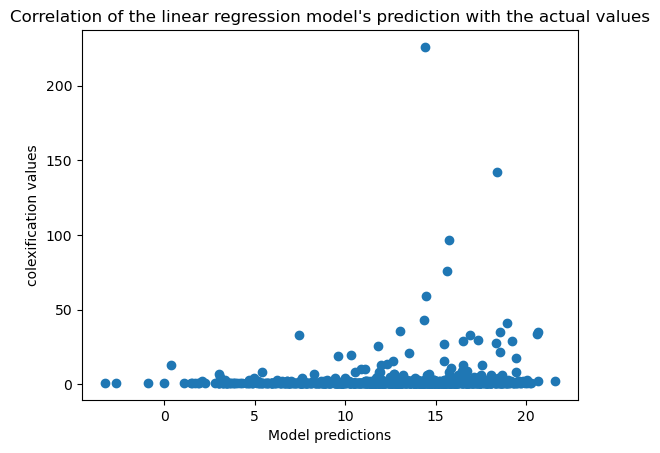

In [92]:
plt.scatter(predictions, y_test)
plt.title("Correlation of the linear regression model's prediction with the actual values")
plt.xlabel("Model predictions")
plt.ylabel("colexification values")

In [116]:
X1_train, X1_test, X2_train, X2_test, y_train, y_test = train_test_split(X1, X2, y, random_state=89)
X1 = final_merged_df[['age_of_acquisition_c1', 'concreteness_c1', 'familiarity_c1', 'imagability_c1']]
X2 = final_merged_df[['age_of_acquisition_c2', 'concreteness_c2', 'familiarity_c2', 'imagability_c2']]
y = final_merged_df['colex_count']
scaler = StandardScaler()
X1_train_scaled = scaler.fit_transform(X1_train)
X1_test_scaled = scaler.transform(X1_test)
X2_train_scaled = scaler.fit_transform(X2_train)
X2_test_scaled = scaler.transform(X2_test) 
optimal_weights = logistic_filtered.loc[90]["Optimal Weights (RMSE objective)"]
predictions1_test1 = X1_test_scaled.dot(optimal_weights[:-1]) 
predictions2_test1 = X2_test_scaled.dot(optimal_weights[:-1])
predictions = predictions1_test1 + predictions2_test1 + optimal_weights[-1]

Text(0, 0.5, 'colexification values')

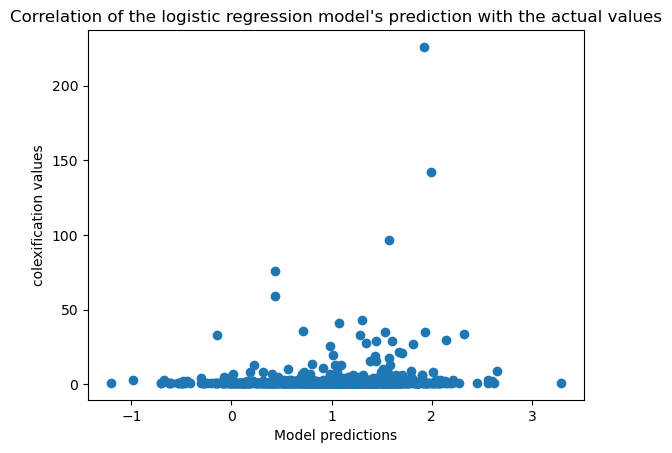

In [117]:
plt.scatter(predictions, y_test)
plt.title("Correlation of the logistic regression model's prediction with the actual values")
plt.xlabel("Model predictions")
plt.ylabel("colexification values")

In [122]:
sum(abs(predictions - y_test))

1911.6921815636015

# Pre-existing demo code on obtaining colexification counts

In [ ]:
def per_lang_colexification(curr_df):
    """
    Calculate the colexification frequency of pairs of concepts present in the current language.
    """
    all_combos_dict = {}
    # We iterate through each row, which has the concepts associated with a specific word
    for i, row in curr_df.iterrows():
        # Get the current set of concepts
        a = row['concepticon_gloss']
        # Create all possible unique combinations of concepts, where each pair is alphabetically sorted
        combos = list(set(map(lambda x: tuple(sorted(x)), product(a, a))))
        # Ensure the concepts in the pair are not identical
        combos = [combo for combo in combos if combo[0] != combo[1]]
        # Add counts for a pair of combinations being colexified
        for combo in combos:
            if combo in all_combos_dict:
                all_combos_dict[combo] += 1
            else:
                all_combos_dict[combo] = 1

    # Create a DataFrame out of our dictionary and return the colexification counts for two concepts
    tmp = pd.DataFrame.from_dict(all_combos_dict, "index").reset_index()
    per_lang = pd.DataFrame(tmp['index'].tolist(), columns=['concept_1', "concept_2"])
    per_lang['colexification_count'] = tmp[0]
    return per_lang

In [ ]:
def main():
    all_dfs = []
    for variety in tqdm(df['variety'].unique()):
        sub = df[df['variety'] == variety]
        agg = sub.groupby("clics_form")[['concepticon_gloss', 'concepticon_id']].agg(list)
        agg['num_concepts'] = agg['concepticon_gloss'].apply(lambda x: len(set(x)))
        colex = agg[agg['num_concepts']>1]
        colex['concepticon_gloss'] = colex['concepticon_gloss'].apply(lambda x: sorted(list(set(x))))
        # We skip any language where no concepts are colexified
        if colex.shape[0] == 0:
            continue
        curr_df = per_lang_colexification(colex)
        all_dfs.append(curr_df)
    mega = pd.concat(all_dfs)
    colex_counts = mega.groupby(["concept_1", "concept_2"]).sum().reset_index()
    return colex_counts
c_count = main()
c_count.to_csv("colex_counts.csv", index=False)